# A weather-based energy forecasting project.

* **Your Name Here:** Geethasree Madiraju Nagaraju

Energy demand forecasting as a function of weather data is an extremely interesting and relevant topic.

I've given you a curated (mostly?) clean dataset that you can use to predict `df['Demand']` as a function of the weather variables.

Of course, you cannot use the df[`Datetime`] column directly into the model - but you can feature engineer the column to make features temporal features for modeling like Julian day of year (0-365), week of year, and number of years since 2012.


* Sort the data from oldest to newest.

* Describe and impute (or drop) the missing values using an appropriate method. At this time, you are welcome to perform feature engineering (optional).

* Process the data as a 3D tensor with a lookback of your choice (use a value greater than or equal to 12).

**Model Architecure:**
Use a model with:
* at least two recurrent layers
* at least one convolution layer
* dropout (recurrent or between Dense layers)
* appropriate activation functions

**Experiments:**
Freeze the model architecutre and perform a *walk-forward validation* where:
* the first 50k samples predict the remaining ~46k samples
* the first 80k samples predict the remaining ~16k samples

Walk-forward validation is very common to use on the job - it shows how your model (ideally) gets better over time as it gets more data to use. Use subheads

**Evaluation**
Evaluate your model for each of these experiments - hopefully, your model should improve as you give it more data to use! But that depends on your choice of architecture. You should have:
* quantitative error metrics (mean absolute error and others)
* scatterplots of actual vs. predicted
* time series plots of actual vs. predicted

You should also compare to baseline model like persistence (assume today's energy usage is the same as yesterday's - requires you to shift by 24... ask on discussion board if questions!) or ignore the sequence data and treat this as a 2D problem (a regular supervised learning problem!)

**Conclusions**
* What did you learn from this assignment? Did your walk-forward validation work as you expected it to?
* What else would you do differently next time?
* At least five great bullets please.

In [3]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# model layers
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error

## Load Data

In [4]:
# https://drive.google.com/file/d/1xYe3vCKTLeaJKpMDzv57ppCSWK_LCJ5V/view?usp=sharing
!gdown 1xYe3vCKTLeaJKpMDzv57ppCSWK_LCJ5V

Downloading...
From: https://drive.google.com/uc?id=1xYe3vCKTLeaJKpMDzv57ppCSWK_LCJ5V
To: /content/BDL_cleanweather_energy (1).csv
100% 7.38M/7.38M [00:00<00:00, 243MB/s]


In [5]:
df = pd.read_csv('BDL_cleanweather_energy (1).csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96427 entries, 0 to 96426
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  96427 non-null  object 
 1   Demand    96427 non-null  float64
 2   BDL_tmpf  96160 non-null  float64
 3   BDL_dwpf  96160 non-null  float64
 4   BDL_relh  96160 non-null  float64
 5   BDL_drct  96160 non-null  float64
 6   BDL_sknt  96160 non-null  float64
 7   BDL_p01i  96160 non-null  float64
 8   BDL_alti  96160 non-null  float64
 9   BDL_mslp  96160 non-null  float64
 10  BDL_vsby  96160 non-null  float64
dtypes: float64(10), object(1)
memory usage: 8.1+ MB


In [6]:
df.head(5)

,Datetime,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby
0,2019-01-01 00:00:00,2713.617,37.9,37.9,100.0,360.0,4.0,0.0700,29.88,1009.7,5.0
1,2019-01-01 01:00:00,2578.343,37.9,37.9,100.0,360.0,4.0,0.1100,29.79,1006.3,2.0
2,2019-01-01 02:00:00,2467.969,37.9,37.9,100.0,340.0,7.0,0.0100,29.70,1003.3,2.0
3,2019-01-01 03:00:00,2397.140,37.9,37.9,100.0,310.0,6.0,0.0100,29.63,1002.3,1.5
4,2019-01-01 04:00:00,2381.258,37.9,37.9,100.0,140.0,3.0,0.0001,29.58,1001.2,1.5


## Sort the data from oldest to newest

In [7]:
# Convert the 'Datetime' column to datetime data type
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Sort the DataFrame by the 'Datetime' column in ascending order and reset index
df = df.sort_values(by='Datetime').reset_index(drop=True)

df.head(5)

,Datetime,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby
0,2011-01-01 00:00:00,3053.0,33.98,26.96,0.0,0.0,0.0,0.0,30.07,1018.5,6.0
1,2011-01-01 01:00:00,2892.0,33.98,26.96,0.0,0.0,0.0,0.0,30.07,1018.5,6.0
2,2011-01-01 02:00:00,2774.0,30.92,26.96,0.0,0.0,0.0,0.0,30.07,1018.6,6.0
3,2011-01-01 03:00:00,2710.0,30.02,26.06,0.0,0.0,0.0,0.0,30.09,1019.2,5.0
4,2011-01-01 04:00:00,2698.0,28.94,24.98,0.0,0.0,0.0,0.0,30.09,1019.1,5.0


In [8]:
df.tail(5)

,Datetime,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby
96422,2021-12-31 19:00:00,3310.60,48.0,45.0,89.29,190.0,7.0,0.0,29.95,1014.2,6.0
96423,2021-12-31 20:00:00,3148.00,48.0,46.0,92.74,190.0,5.0,0.0,29.95,1013.8,5.0
96424,2021-12-31 21:00:00,2988.93,48.0,46.0,92.74,170.0,7.0,0.0,29.94,1013.5,5.0
96425,2021-12-31 22:00:00,2793.70,46.9,46.4,100.00,180.0,7.0,0.0,29.94,1013.8,5.0
96426,2021-12-31 23:00:00,2629.35,48.0,46.0,92.74,160.0,5.0,0.0,29.94,1013.3,4.0


## Missing Value Imputation

In [9]:
#check the missing value percentage of each column
(df.isna().sum()/df.shape[0])*100

Datetime    0.000000
Demand      0.000000
BDL_tmpf    0.276893
BDL_dwpf    0.276893
BDL_relh    0.276893
BDL_drct    0.276893
BDL_sknt    0.276893
BDL_p01i    0.276893
BDL_alti    0.276893
BDL_mslp    0.276893
BDL_vsby    0.276893
dtype: float64

In [10]:
#describe all the columns
df.select_dtypes(include = np.number).describe()

,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby
count,96427.000000,96160.000000,96160.000000,96160.000000,96160.000000,96160.000000,96160.000000,96160.000000,96160.000000,96160.000000
mean,3388.580129,51.951929,39.643082,65.596163,221.359297,7.566077,0.005532,30.018212,1010.126411,9.340668
std,761.491626,19.318457,19.695832,21.408473,118.585969,4.771563,0.037132,0.290565,80.112071,1.978791
min,1372.000000,-11.020000,-27.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2843.000000,36.000000,24.980000,49.440000,170.000000,4.000000,0.000000,29.870000,1011.200000,10.000000
50%,3333.420000,52.000000,41.000000,66.635000,230.000000,7.000000,0.000000,30.020000,1016.300000,10.000000
75%,3813.000000,68.000000,55.940000,84.440000,330.000000,10.000000,0.000000,30.170000,1021.500000,10.000000
max,7219.000000,102.020000,78.080000,100.000000,360.000000,40.000000,1.960000,30.850000,1044.700000,10.000000


Around 0.27% of the data is missing from each of the features. Since all are numeric features, imputing with median for all the missing features

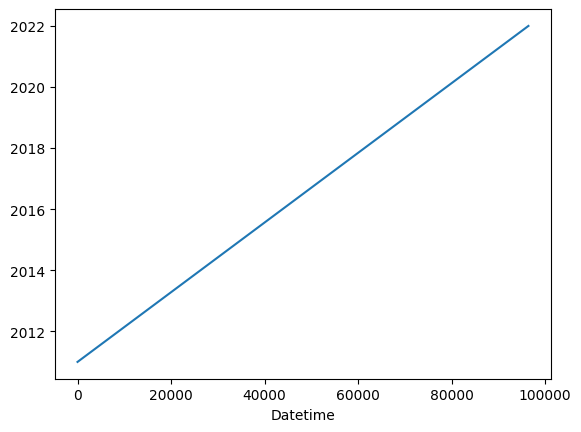

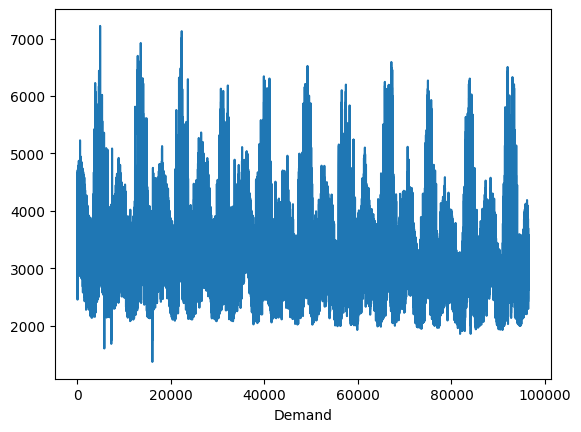

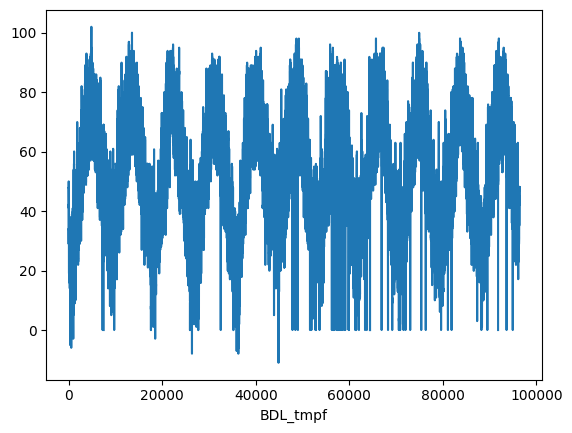

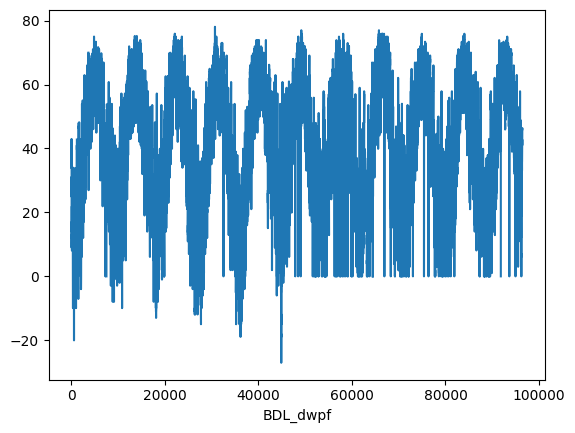

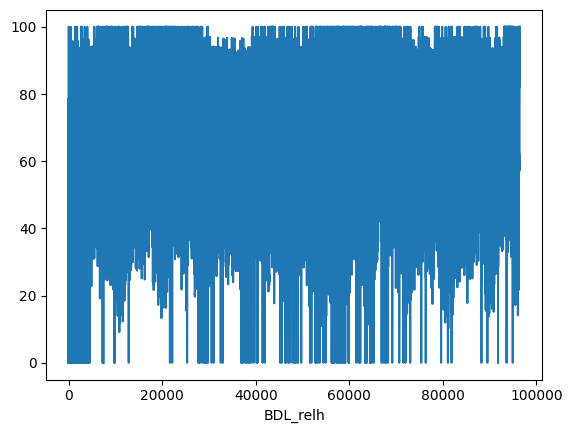

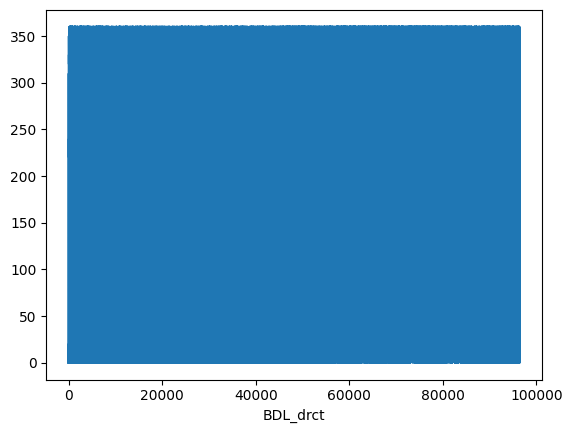

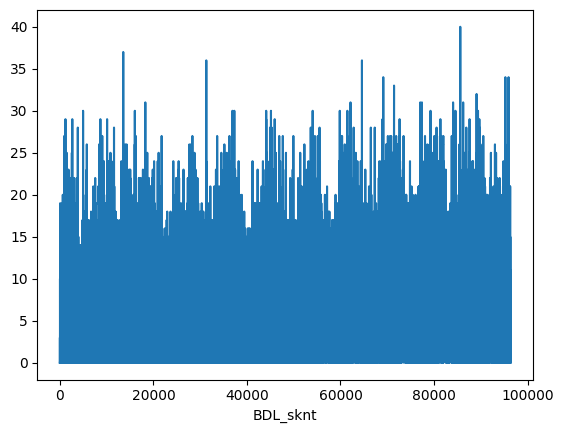

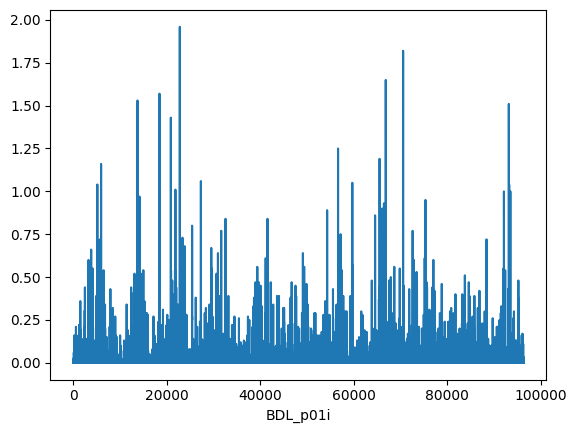

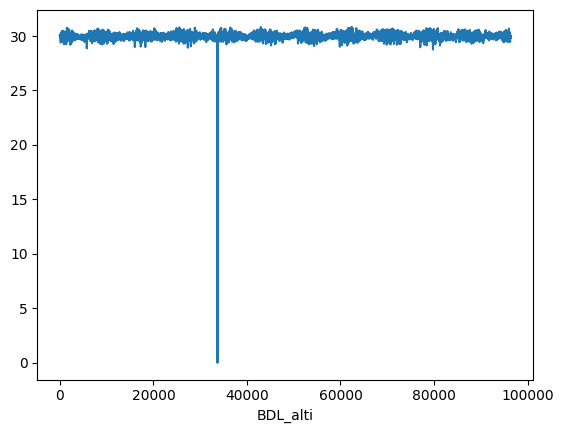

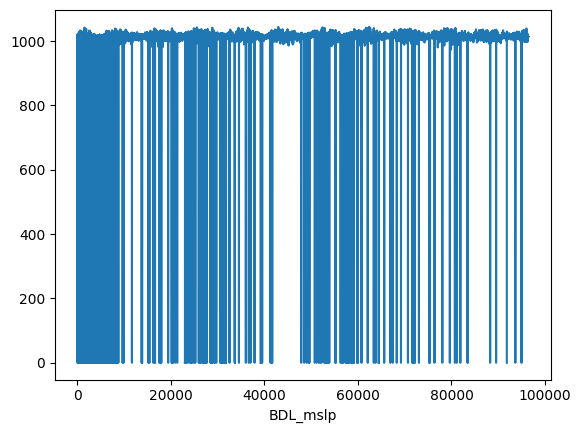

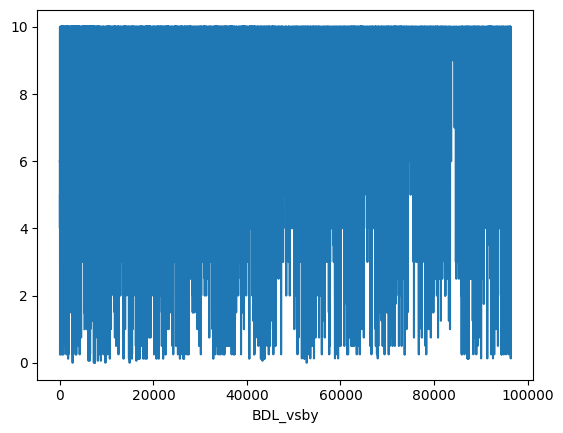

In [11]:
#plotting time series of all the columns
for col in df.columns:
  df[col].plot()
  plt.xlabel(col)
  plt.show()

Imputing the missing data with forward fill imputation technique, where imputed value is same as value at previous time step.

In [12]:
#get the list of missing value columns
missing_value_cols = [col for col in df.columns if df[col].isna().any()]
print(missing_value_cols)

#impute missing value columns with median - as all the columns are numerical
for col in missing_value_cols:
  # df[col] = df[col].fillna(df[col].median())
  df[col] = df[col].fillna(method='ffill')

#check if all missing values are imputed
df.info()

['BDL_tmpf', 'BDL_dwpf', 'BDL_relh', 'BDL_drct', 'BDL_sknt', 'BDL_p01i', 'BDL_alti', 'BDL_mslp', 'BDL_vsby']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96427 entries, 0 to 96426
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  96427 non-null  datetime64[ns]
 1   Demand    96427 non-null  float64       
 2   BDL_tmpf  96427 non-null  float64       
 3   BDL_dwpf  96427 non-null  float64       
 4   BDL_relh  96427 non-null  float64       
 5   BDL_drct  96427 non-null  float64       
 6   BDL_sknt  96427 non-null  float64       
 7   BDL_p01i  96427 non-null  float64       
 8   BDL_alti  96427 non-null  float64       
 9   BDL_mslp  96427 non-null  float64       
 10  BDL_vsby  96427 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 8.1 MB


Since we already have data at hourly level, we can forecast the demand for every hour, hence additional data aggregation need not be performed.

In [13]:
# Creating new features from the data like Julian day of year (0-365), week of year, and number of years since 2012.
# Convert the 'Datetime' column to datetime type
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Feature: Julian day of year (0-365)
df['julian_day'] = df['Datetime'].dt.dayofyear - 1

# Feature: Week of year
df['week_of_year'] = ((df['Datetime'].dt.dayofyear - 1) // 7) + 1

# Feature: Number of years since 2012
df['years_since_2012'] = df['Datetime'].dt.year - 2012

# drop the Datetime column
df.drop(['Datetime'], inplace=True, axis=1)

## Data Preparation

In [14]:
df.head(5)

,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby,julian_day,week_of_year,years_since_2012
0,3053.0,33.98,26.96,0.0,0.0,0.0,0.0,30.07,1018.5,6.0,0,1,-1
1,2892.0,33.98,26.96,0.0,0.0,0.0,0.0,30.07,1018.5,6.0,0,1,-1
2,2774.0,30.92,26.96,0.0,0.0,0.0,0.0,30.07,1018.6,6.0,0,1,-1
3,2710.0,30.02,26.06,0.0,0.0,0.0,0.0,30.09,1019.2,5.0,0,1,-1
4,2698.0,28.94,24.98,0.0,0.0,0.0,0.0,30.09,1019.1,5.0,0,1,-1


In [15]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in np.arange(len(sequences)): # be careful of this line!
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, 1:], sequences[end_ix-1, 0]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

## Experiment 1a: Train on 50k, predict on rest 46k, Lookback of 48

### Exp 1a: Data Prep

In [ ]:
# use split_sequences to split get sequential data with n_steps
n_steps = 48
raw_seq = np.array(df)
X, y = split_sequences(raw_seq, n_steps)
print(X.shape)
print(y.shape)


#train test split
train_pct_index = 50000
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(96380, 48, 12)
(96380,)
(96380, 48, 12) (50000, 48, 12) (46380, 48, 12)
(96380,) (50000,) (46380,)


### Exp 1a: Model Fit

In [ ]:
n_steps = X_train.shape[1]
n_features = X_train.shape[2]

# define model
#best model architecture
model = Sequential()
model.add(Conv1D(filters=15, kernel_size=3, input_shape=(n_steps,n_features)))
model.add(MaxPooling1D(2))
model.add(LSTM(20, input_shape=(n_steps,n_features), return_sequences=True, activation='relu',recurrent_dropout = 0.1))
# model.add(GRU(15, input_shape=(n_steps,n_features), return_sequences=True, activation='relu',recurrent_dropout = 0.2))
# model.add(SimpleRNN(15, input_shape=(n_steps,n_features), return_sequences=True, activation='relu',recurrent_dropout = 0.2))
model.add(SimpleRNN(10, input_shape=(n_steps,n_features), activation='relu',recurrent_dropout = 0.1))
model.add(Dense(1, activation='linear'))
model.summary()


model.compile(optimizer='adam', loss='mse',metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)
#return history to plot the losses as learning progresses
history = model.fit(X_train, y_train,
          epochs=200,
          batch_size=20,
          validation_split=0.2,
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_29 (Conv1D)          (None, 46, 15)            555       
                                                                 
 max_pooling1d_29 (MaxPooli  (None, 23, 15)            0         
 ng1D)                                                           
                                                                 
 lstm_22 (LSTM)              (None, 23, 20)            2880      
                                                                 
 simple_rnn_33 (SimpleRNN)   (None, 10)                310       
                                                                 
 dense_29 (Dense)            (None, 1)                 11        
                                                                 
Total params: 3756 (14.67 KB)
Trainable params: 3756 (14.67 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

### Exp 1a: Performance Metrics

In [ ]:
#using the final model to predict on Train and Test partitions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# MAE, RMSE, R2 for each partition
# R2 score
print("R2 score on train predictions: ",r2_score(y_train, train_preds))
print("R2 score on test predictions: ",r2_score(y_test,test_preds))

# MAE - Mean Absolute Error
print("Mean Absolute Error on train predictions",mean_absolute_error( y_train, train_preds))
print("Mean Absolute Error on test predictions",mean_absolute_error( y_test, test_preds))

# RMSE - Root Mean Square Error
print("Root Mean Square Error on train predictions",mean_squared_error( y_train, train_preds))
print("Root Mean Square Error on test predictions",mean_squared_error( y_test, test_preds))

1450/1450 [==============================] - 8s 6ms/step
R2 score on train predictions:  0.5912758042637443
R2 score on test predictions:  0.5351545175783465
Mean Absolute Error on train predictions 412.5963402741016
Mean Absolute Error on test predictions 398.055150181121
Root Mean Square Error on train predictions 245662.55118526708
Root Mean Square Error on test predictions 239411.06599298344


Upon trying different combinations of two RNN layers (LSTM + SimpleRNN, GRU+ SimpleRNN, SimpleRNN+SimpleRNN), LSTM+SimpleRNN yielded best performance metrics in terms of validation MAE and test R2 Score. Hence freezing this model architecture for further experiments.

## Experiment 1b: Train on 50k, predict on rest 46k, Lookback of 24

### Exp 1b :Data Prep

In [ ]:
# use split_sequences to split get sequential data with n_steps
n_steps = 24
raw_seq = np.array(df)
X, y = split_sequences(raw_seq, n_steps)
print(X.shape)
print(y.shape)


#train test split
train_pct_index = 50000
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

### Exp 1b: Model Fit

In [ ]:
# # model architecture
# at least two recurrent layers
# at least one convolution layer
# dropout (recurrent or between Dense layers)
# appropriate activation functions

In [ ]:
n_steps = X_train.shape[1]
n_features = X_train.shape[2]

# define model
#best model architecture
model = Sequential()
model.add(Conv1D(filters=15, kernel_size=3, input_shape=(n_steps,n_features)))
model.add(MaxPooling1D(2))
model.add(LSTM(20, input_shape=(n_steps,n_features), return_sequences=True, activation='relu',recurrent_dropout = 0.1))
model.add(SimpleRNN(10, input_shape=(n_steps,n_features), activation='relu',recurrent_dropout = 0.1))
model.add(Dense(1, activation='linear'))
model.summary()


model.compile(optimizer='adam', loss='mse',metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)
#return history to plot the losses as learning progresses
history = model.fit(X_train, y_train,
          epochs=200,
          batch_size=20,
          validation_split=0.2,
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 22, 15)            555       
                                                                 
 max_pooling1d_30 (MaxPooli  (None, 11, 15)            0         
 ng1D)                                                           
                                                                 
 lstm_23 (LSTM)              (None, 11, 20)            2880      
                                                                 
 simple_rnn_34 (SimpleRNN)   (None, 10)                310       
                                                                 
 dense_30 (Dense)            (None, 1)                 11        
                                                                 
Total params: 3756 (14.67 KB)
Trainable params: 3756 (14.67 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

### Exp 1b: Performance Metrics

In [ ]:
#using the final model to predict on Train and Test partitions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# MAE, RMSE, R2 for each partition
# R2 score
print("R2 score on train predictions: ",r2_score(y_train, train_preds))
print("R2 score on test predictions: ",r2_score(y_test,test_preds))

# MAE - Mean Absolute Error
print("Mean Absolute Error on train predictions",mean_absolute_error( y_train, train_preds))
print("Mean Absolute Error on test predictions",mean_absolute_error( y_test, test_preds))

# RMSE - Root Mean Square Error
print("Root Mean Square Error on train predictions",mean_squared_error( y_train, train_preds))
print("Root Mean Square Error on test predictions",mean_squared_error( y_test, test_preds))

1451/1451 [==============================] - 5s 3ms/step
R2 score on train predictions:  0.7991701152932117
R2 score on test predictions:  0.7387746249448051
Mean Absolute Error on train predictions 274.44279478597656
Mean Absolute Error on test predictions 285.12175082769164
Root Mean Square Error on train predictions 120702.50410043154
Root Mean Square Error on test predictions 134513.73283232693


## Experiment 1(best): Actual vs Predicted Comparison

Model trained on sequential data with lookback period of 24 hours yielded a better performance than that of data with lookback period of 48 hours. Looking at actual vs predicted energy demand with this as final model.

#### Scatterplot

<Figure size 1000x500 with 0 Axes>

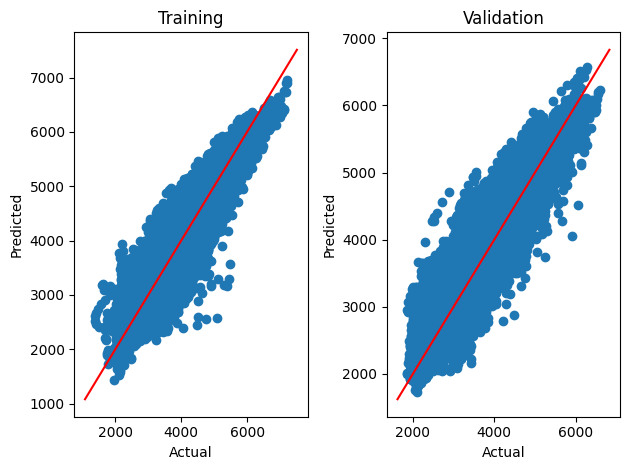

In [304]:
# scatterplot of actual vs. pred
# specify the dimensions
plt.figure(figsize=(10,5))
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
axes[0].scatter(x=y_train, y=train_preds)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')


# Validation Results
axes[1].scatter(x=y_test, y=test_preds)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

#### Time Series Plot

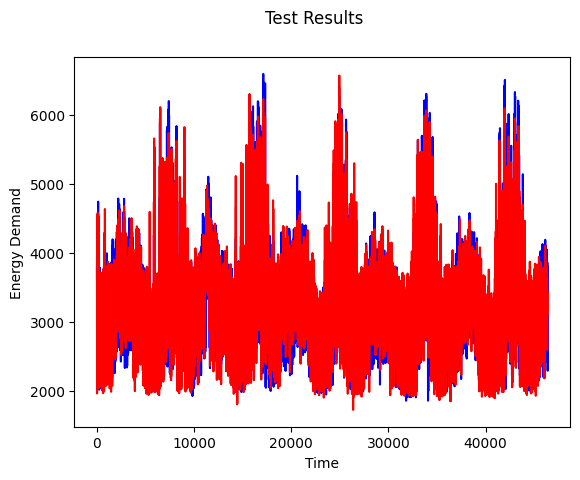

In [305]:
# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), test_preds, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy Demand')
plt.show()

## Experiment 2:Train on 80k, predict on rest 16k, Lookback of 24

### Exp2: Data Prep

In [16]:
# use split_sequences to split get sequential data with n_steps
n_steps = 24
raw_seq = np.array(df)
X, y = split_sequences(raw_seq, n_steps)
print(X.shape)
print(y.shape)


#train test split
train_pct_index = 80000
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(96404, 24, 12)
(96404,)
(96404, 24, 12) (80000, 24, 12) (16404, 24, 12)
(96404,) (80000,) (16404,)


### Exp 2: Model Fit

In [17]:
n_steps = X_train.shape[1]
n_features = X_train.shape[2]

# define model
#best model architecture
model = Sequential()
model.add(Conv1D(filters=15, kernel_size=3, input_shape=(n_steps,n_features)))
model.add(MaxPooling1D(2))
model.add(LSTM(20, input_shape=(n_steps,n_features), return_sequences=True, activation='relu',recurrent_dropout = 0.1))
model.add(SimpleRNN(10, input_shape=(n_steps,n_features), activation='relu',recurrent_dropout = 0.1))
model.add(Dense(1, activation='linear'))
model.summary()


model.compile(optimizer='adam', loss='mse',metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)
#return history to plot the losses as learning progresses
history = model.fit(X_train, y_train,
          epochs=200,
          batch_size=20,
          validation_split=0.2,
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 15)            555       
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 15)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 11, 20)            2880      
                                                                 
 simple_rnn (SimpleRNN)      (None, 10)                310       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 3756 (14.67 KB)
Trainable params: 3756 (14.67 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

### Exp2: Performance Metrics

In [18]:
#using the final model to predict on Train and Test partitions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# MAE, RMSE, R2 for each partition
# R2 score
print("R2 score on train predictions: ",r2_score(y_train, train_preds))
print("R2 score on test predictions: ",r2_score(y_test,test_preds))

# MAE - Mean Absolute Error
print("Mean Absolute Error on train predictions",mean_absolute_error( y_train, train_preds))
print("Mean Absolute Error on test predictions",mean_absolute_error( y_test, test_preds))

# RMSE - Root Mean Square Error
print("Root Mean Square Error on train predictions",mean_squared_error( y_train, train_preds))
print("Root Mean Square Error on test predictions",mean_squared_error( y_test, test_preds))

513/513 [==============================] - 2s 3ms/step
R2 score on train predictions:  0.7602672584574428
R2 score on test predictions:  0.7814369519214375
Mean Absolute Error on train predictions 299.2700951747071
Mean Absolute Error on test predictions 274.96040465918657
Root Mean Square Error on train predictions 137405.40164747514
Root Mean Square Error on test predictions 119015.77682201496


 With best model architecture and look back period of 48 hrs, used first 80k samples of data for training and validated the model on rest of the data. Upon comparing the performance metrics, model trained on 80k samples of data performed better than model trained on 50k samples of data. This is expected as model tends to perform well as it sees more training data.

### Experiment 2: Actual vs Predicted Comparison

#### Scatterplot

<Figure size 1000x500 with 0 Axes>

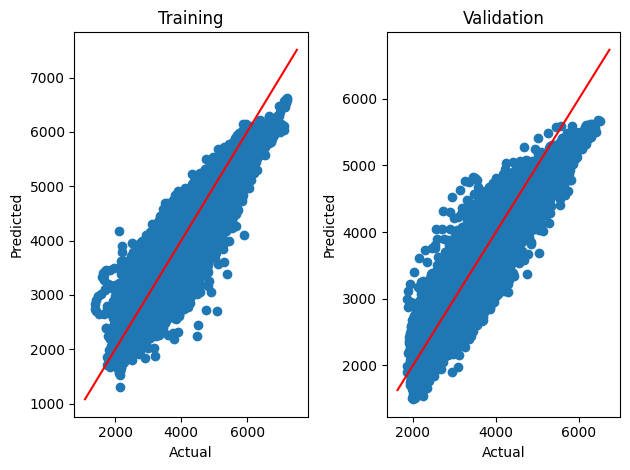

In [19]:
# scatterplot of actual vs. pred
# specify the dimensions
plt.figure(figsize=(10,5))
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
axes[0].scatter(x=y_train, y=train_preds)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')


# Validation Results
axes[1].scatter(x=y_test, y=test_preds)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

#### Time Series Plot

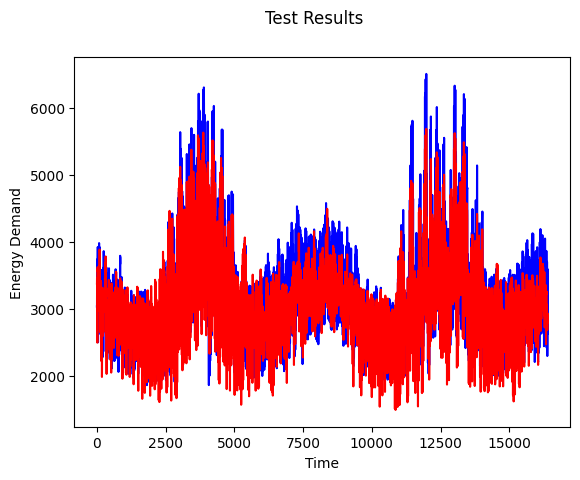

In [20]:
# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), test_preds, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy Demand')
plt.show()

## Baseline Model Comparison
Considering Baseline Model as the one that predicts todays energy demand same as yesterdays. Hence shifting the data by 24 observations.

In [21]:
df['Baseline'] = df['Demand'].shift(24)
y_test_pred_baseline = df['Baseline']
y_test_pred_baseline = y_test_pred_baseline.tail(y_test.shape[0])
print(y_test.shape)
print(y_test_pred_baseline.shape)

(16404,)
(16404,)


In [22]:
# MAE, RMSE, R2 for each partition
# R2 score
print("R2 score on test predictions: ",r2_score(y_test,y_test_pred_baseline))

# MAE - Mean Absolute Error
print("Mean Absolute Error on test predictions",mean_absolute_error(y_test, y_test_pred_baseline))

# RMSE - Root Mean Square Error
print("Root Mean Square Error on test predictions",mean_squared_error(y_test, y_test_pred_baseline))

R2 score on test predictions:  0.7729255581238592
Mean Absolute Error on test predictions 242.12189155084127
Root Mean Square Error on test predictions 123650.54996213308


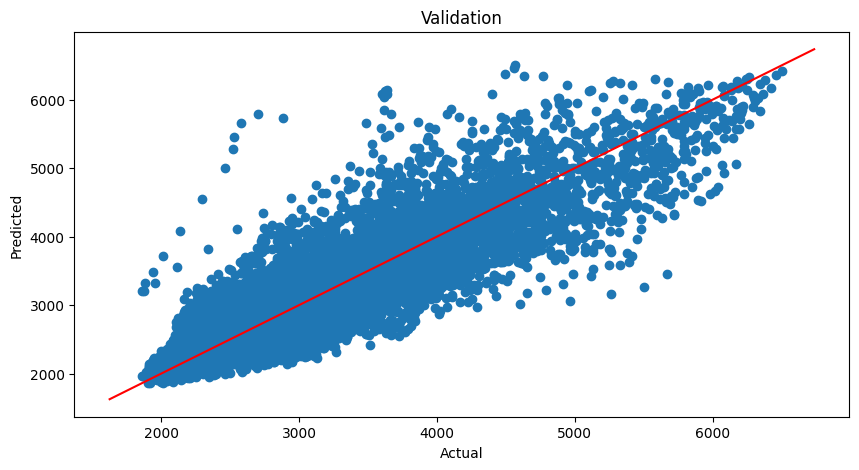

In [23]:
# scatterplot of actual vs. pred
# specify the dimensions
plt.figure(figsize=(10,5))

# Validation Results
plt.scatter(x=y_test, y=y_test_pred_baseline)
plt.xlabel("Actual", fontsize=10)
plt.ylabel("Predicted",  fontsize=10)
plt.title("Validation")
# add 45 deg line
x = np.linspace(*plt.xlim())
plt.plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

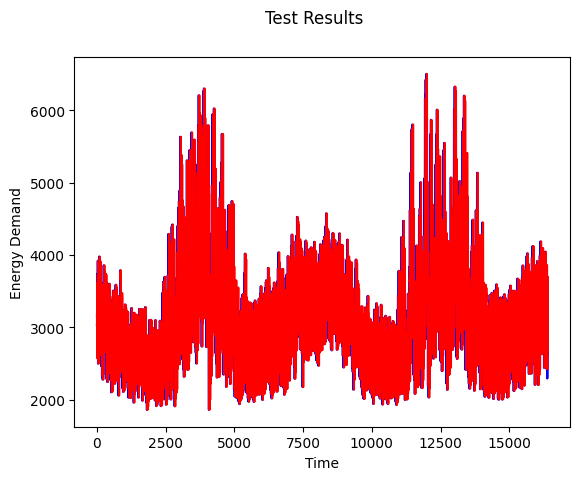

In [24]:
# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), y_test_pred_baseline, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy Demand')
plt.show()

## Bullets
**LSTM vs GRU comparison performance**: In Experiment 1, where model was fit on first 50k samples and validated on rest of the samples, with a lookback period of 24 hours, experimented with different model architectures (LSTM+RNN, GRU+RNN, RNN+RNN) for learning from sequential data . LSTM+RNN yielded better performance in terms of validation MAE and test R2 scores when compared to other combinations.  <br/>
**lookback of 24 vs 48 comparison**: After selecting the best model architecture, experimented with a lookback period of 24 and 48. Observed that using a lookback of 24 yielded slightly better performance metrics in terms of validation MAE and Test R2 score.  <br/>
**Walk forward validation comparison**: Model fit on 84k samples of data (Experiment 2) yielded better performance than model trained on 50k samples (Experiment 1). From the times series plot of actual vs predicted, it can be observed that the model from experiment 2 was better able to generalize on the peaks and valleys in the data.<br/>
**Best Batch size**: Upon choosing a low batch size of 5-10, each epoch took longer time to converge, but validation mae converged quickly to optimal value. For a higher batch size around 50-100, model takes more epochs to converge. I have chosen a batch size of 20 and a patience value of 10 for better convergence<br/>
**Comparison with Baseline Persistence Model**: Created a Baseline persistence model where predicted energy demand is equal to energy demand 24 hours prior to the current hour and predicted for test sample size obtained from Experiment 2. Comparing the baseline model with with best Model (Model from experiment 2) in terms of val MAE and test R2 Score, it can be observed that Model from experiment 2 performed only slightly better than persistence model.  <br/>